## Задача: обучить VLM отвечать на вопросы по графикам

---
#### Выбрать существующую VLM
---

Разберем примеры некоторых известных VLMs:
- **CLIP** (Contrastive Language-Image Pretraining)
- **BLIP** (Bootstrapping Language-Image Pretraining)
- **OFA** (One For All)
- **LLaVA** (Large Language and Vision Assistant)
- **Google DePlot**

##### Проанализируем данные на претрейне и их релевантность для Chart Question Answering
1. **CLIP**<br>Мощная модель в задачах сопоставления изображений и текстов
   - Не имеет специального обучения на графиках и диаграммах
2. **BLIP**<br>Хорошо работает с задачами генерации текста по изображениям и QA
   - Не имеет специального обучения на графиках
3. **OFA**<br>Универсальная модель, обученная для выполнения множества задач, в т.ч. QA
   - Может потребовать дообучения для специфических задач CQA
4. **LLaVA**<br>Интерактивная модель для обработки графиков и текстовых запросов
   - Хороший выбор для обработки данных в CQA
5. **Google Deplot**<br>Модель на архитектуре Pix2Struct*, специально разработанная для интерпретации и обработки данных из графиков и диаграмм
   - Отлично подходит для задач анализа данных и извлечения информации из визуальных представлений

<sub>\*Pix2Struct предобучен скриншотах веб-страниц для выполнения таких задач, как OCR (Optical Character Recognition) (преобразование текста на изображении в машиночитаемый формат), language modeling (рассчет распределения вероятностей слов в тексте), image captioning (подписи к картинкам)</sub>

Я выберу Google Deplot как наиболее узкопрофильную для поставленной задачи. Размер Google DePlot: 282 миллиона параметров, это относительно небольшая модель, что гарантирует низкую сложность инференса, несмотря на мультимодальность. Средняя сложность квантизации из-за мультимодальности, т.к. квантизация должна учитывать особенности обоих типов данных (текст и изображение), чтобы минимизировать потери точности

---
#### Дайте теоретическое введние в то, как устроены vlm, 
 - что входит в архитектуру
 - как происходит обучение подобных моделей
---

##### Что могут VLM?
Задачи VLM можно разделить на 3 группы<br>
1. **Задачи генерирования**<br>
   - Визуальный ответ на вопрос (VQA, Visual Question Answering) — это процесс, где ответ на вопрос генерируется с учетом визуальных входных данных (изображений или видео)
   - Подпись к визуальным данным (VC, Visual Captioning) — это процесс, где генерируется описание к визуальным входным данным
   - Понимание визуальных данных (VCR, Visual Commonsense Reasoning) — процесс, где визуальные данные интерпретируются с точки зрения общего понимания и когнитивного восприятия
   - Генерирование изображений (VG, Visual Generation) — процесс, при котором визуальные данные создаются на основе текстового запроса, как показано на изображении<br>
2. **Задачи классификации**<br>
   - Мультимодальные эмоциональные вычисления (MAC, Multimodal Affective Computing) — интерпретация визуальных эмоциональных проявлений на основе визуальных и текстовых данных или, в некотором смысле, мультимодальный анализ настроения
   - Естественный язык в оценке визуальных данных (NLVR, Natural Language for Visual Reasoning) — оценка истинности того или иного утверждения о визуальных входных данных<br>
3. **Задачи поиска**
   - Поиск визуальных данных (VR, Visual Retrieval) — сбор изображений исключительно на основании текстового описания.
   - Визуально-языковая навигация (VLN, Vision-Language Navigation) — движение в пространстве, которым программа управляет на основе текстовых инструкций.
   - Мультимодальный машинный перевод (MMT, Multimodal Machine Translation) — перевод описания с одного языка на другой с учетом дополнительной визуальной информации.

VLMs бывают двухпотоковыми и однопотоковыми. Двухпотококая модель означает, что текст и изображение обрабатываются в двух отдельных модулях. Текст кодируется через токены и позиционные эмбеддинги — стандартные для трансформеров процессы. Затем он обрабатывается в модуле внутреннего внимания (self-attention) трансформера. Изображение декомпозируется до отдельных, неперекрывающих друг друга фрагментов, которые затем представляются в виде векторов, подобно эмбеддингам фрагментов из визуальных трансформеров<br>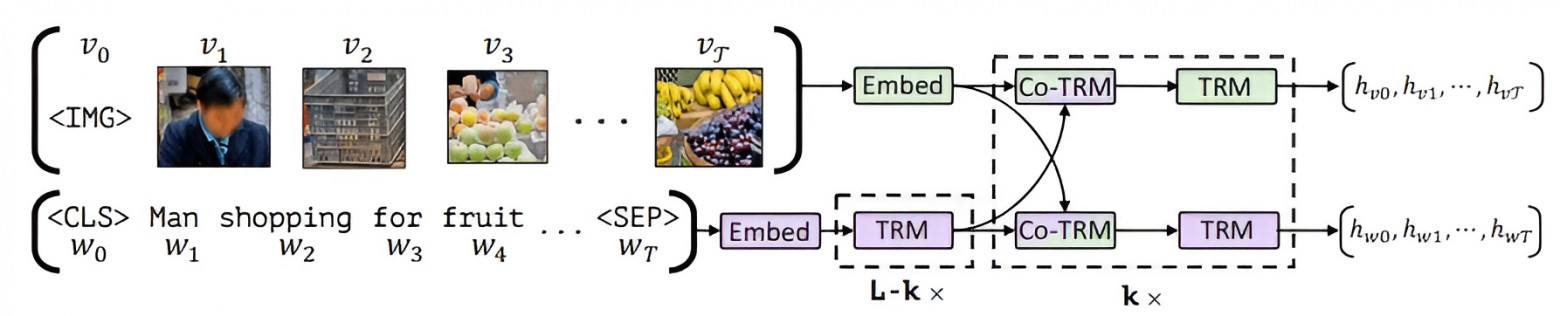<br>
Набор данных, на котором обучается модель, — это пары «изображение + текст», а конечная цель модели — уметь соотностить текст и изображения. Затем предобученную модель можно донастроить под конкретные задачи VL

Однопотоковые модели работают с обеими модальностями работают внутри одного модуля. Например, в VisualBERT используется трансформер, который объединяет области изображения с текстом и обнаруживает соответствия между ними. То есть к стандартной модели BERT добавляются эмбеддинги визуальных данных.

Существует множество разных стратегий, в общем виде обучение состоит из:
- Сбора данных в виде пар изображение-текст
- Предобучение, поиск общих признаков и взаимосвязей между изображениями и текстами
- Дообучение (fine-tuning) для адаптации модели к конкретным типам задач

Как пример, VisualBERT предобучается на парах «изображение + подпись» через маскированное языковое моделирование (Masked Language Modeling) и сопоставление изображений и текстов (Image-Text Matching). Трансформер (LLM) обучается только на тексте, рандомно маскируя часть токенов, и модель учится угадывать замаскированные токены, затем модель прогнозриует совместимость текста и изображения

---
Разберем несколько архитектур более подробно

##### Архитектура и обучение CLIP<br>
CLIP использует т.н. контрастное обучение, т.е. ищет соответствие между представлениями изображений и текста. Объединяются не разные представления одного и того же изображения, а правильные (positive) представления изображения и соответствующего ему текста, и в то же время исключаются тексты, не соответствующие изображению (negative). Это — контрастное обучение с учителем, и для него нужны маркированные пары

##### Архитектура LLaVA<br>
В качестве текстового энкодера LLaVa использует модель LLaMA, LLM на архитектуре трансформера<br>В качестве визуального энкодера LLaVA использует CLIP-ViT-L/14

ViT-L/14 извлекает визуальные признаки (features) из входных изображений и связывает их с языковыми эбмеддингами посредством обучаемой проекционной матрицы (projection matrix). Эта проекция переводит визуальные признаки в языковые эбмеддинги токенов, создавая связь между текстом и изображением

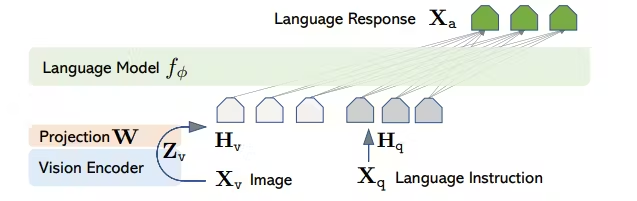

Для входного изображения <i>X<sub>v</sub></i> модель использует предобученный ViT-L/14, который возвращает визуальный признак <i>Z<sub>v</sub></i>. Затем применяется матрица <i>W</i>. Эта проекция переводит визуальные признаки в языковые эбмеддинги токенов <i>H<sub>v</sub></i>. Размерность <i>H<sub>v</sub></i> совпадает с пространством эмбеддингов слов в языковой модели

##### Обучение LLaVA<br>
Обучение LLaVA включает в себя ключевые стадии, которые позволяют воспринимать инструкции пользователя, анализировать визуальный и текстовый контент и генерировать точные ответы:
- Предобучение (Pre-training for Feature Alignment): LLaVA сопостовляет визуальные и текстовые эмбеддинги для совместимости на начальной стадии. Меняются только веса проекционной матрицы
- Дообучение (Fine-tuning End-to-End): Второй этап обучения состоит из дообучения всей модели. Веса визуального энкодера остаются неизменными, а предварительно обученные слои проекции и параметры LLM подстраиваются под новые данные. Такое дообучение позволяет адаптироваться к индивидуальным задачам и по-разному раскрывать возможности модели

Пример использования LLaVA и сравнение с другими визуальными моделями:<br>
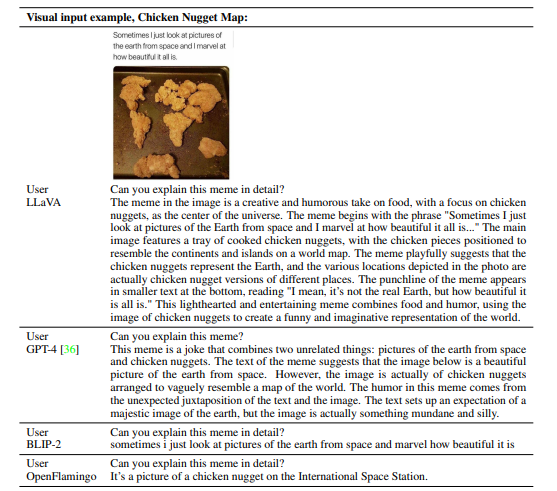<br>Можно видеть, что LLaVA дает более развернутый и точный ответ

---
##### Архитектура Google Deplot

DePlot является визуальным энкодером, который преобразовывает изображение с графиком или диаграммой в разлинованную таблицу. Visual reasoning декомпозируется в 2 этапа:
- Перевод графика в текст
- Анализ переведенного текста

Выходные данные DePlot можно использовать на предобученной LLM, используя few-shot подход (когда модель учится на нескольких примерах, а не на миллионах, как на претрейне)

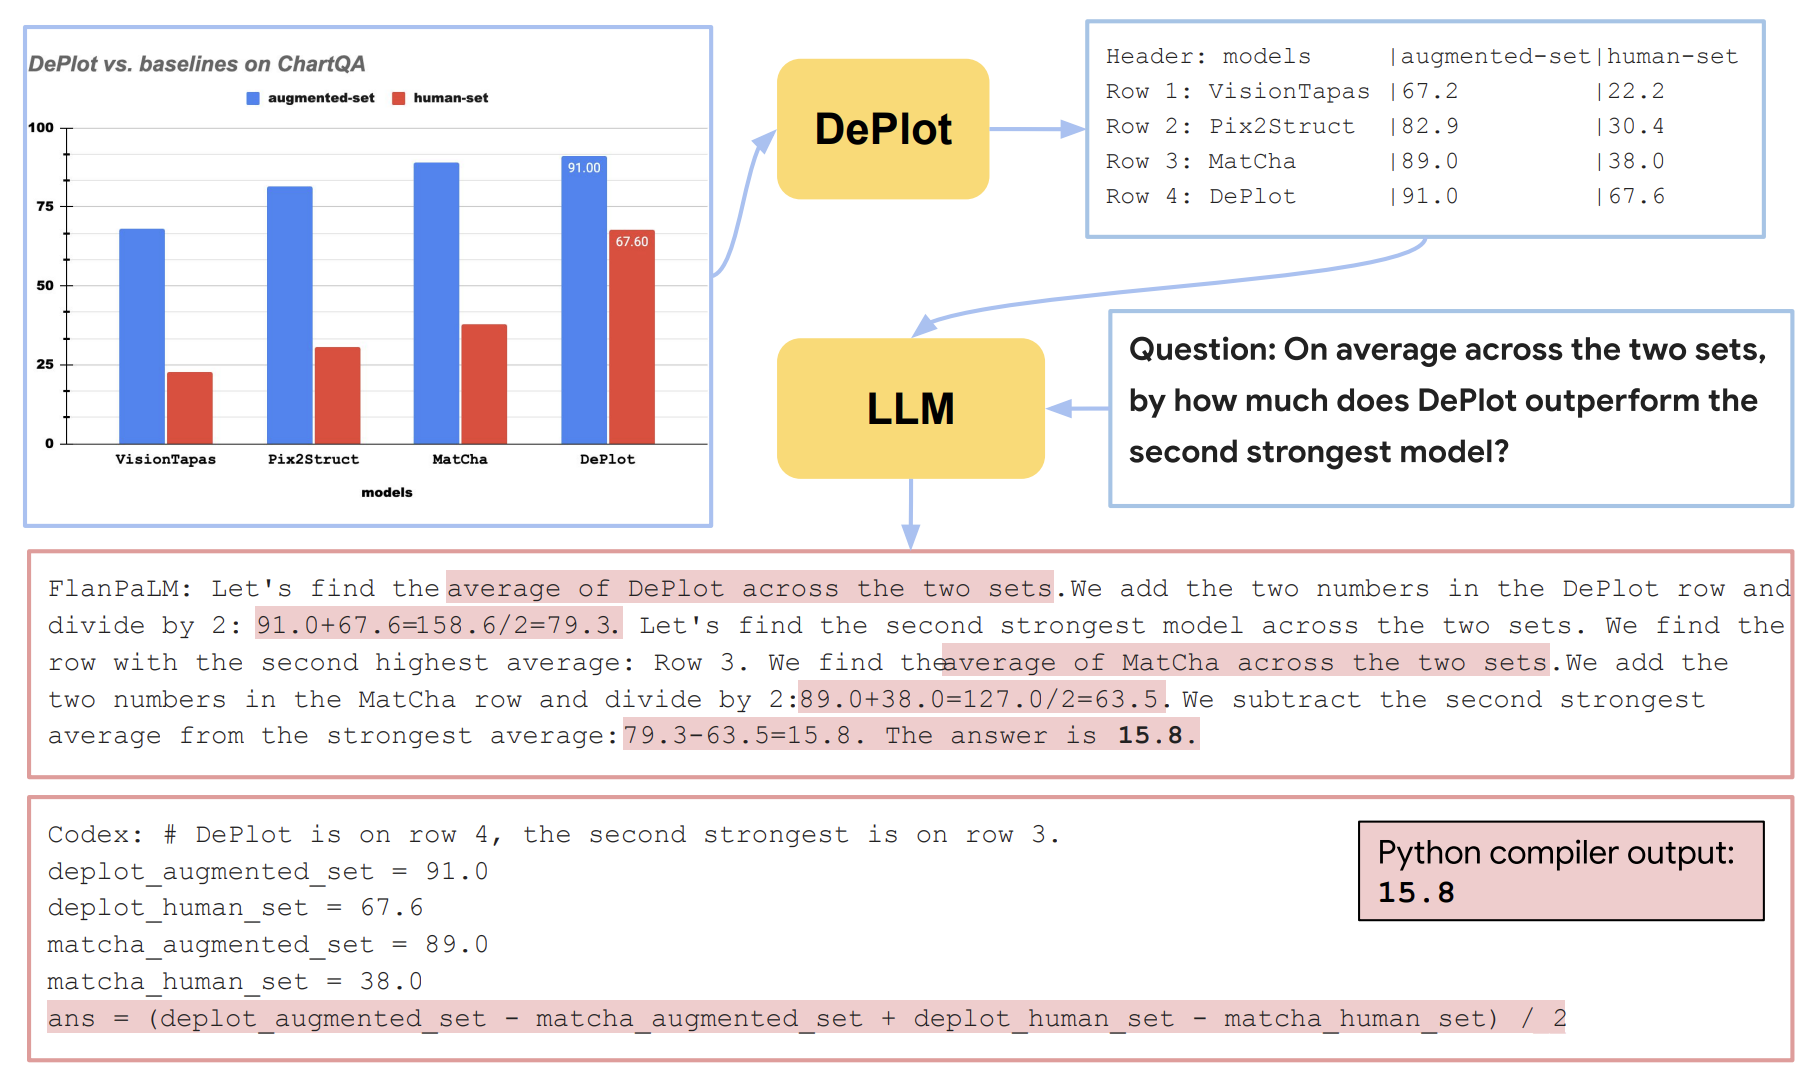

In [2]:
pip install transformers==4.39.1

     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     ----- ------------------------------- 20.5/134.8 kB 640.0 kB/s eta 0:00:01
     ---------------- -------------------- 61.4/134.8 kB 656.4 kB/s eta 0:00:01
     -------------------------------------- 134.8/134.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
    --------------------------------------- 0.1/8.8 MB 7.0 MB/s eta 0:00:02
   - -------------------------------------- 0.3/8.8 MB 3.8 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/8.8 MB 5.1 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/8.8 MB 5.1 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.8 MB 7.1 MB/s eta 0:00:02
   -------- ------------------------------- 1.9/8.8 MB 7.3 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/8.8 MB 6.7 MB/s eta 0:00:02
   ------------- -------------------------- 2.9/8.8 MB 8.1 MB/s eta 0:00:01
   -------


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
import requests
from PIL import Image

In [4]:
processor = Pix2StructProcessor.from_pretrained('google/deplot')
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')

C:\Users\User\Desktop\internship\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

C:\Users\User\Desktop\internship\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--google--deplot. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [5]:
url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")
predictions = model.generate(**inputs, max_new_tokens=512)
print(processor.decode(predictions[0], skip_special_tokens=True))

Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

C:\Users\User\Desktop\internship\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--ybelkada--fonts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Entity | Individuals responsibility | Government's responsibility <0x0A> MEDIAN | 39.0 | 55.0 <0x0A> Germany | nan | 35.0 <0x0A> UK | 45.0 | 49.0 <0x0A> Sweden | 37.0 | 53.0 <0x0A> Denmark | 42.0 | 54.0 <0x0A> France | 38.0 | 55.0 <0x0A> Netherla nns | 40.0 | 58.0 <0x0A> Spain | 29.0 | 63.0 <0x0A> Italy | 22.0 | 74.0


In [6]:
print(processor.decode(predictions[0], skip_special_tokens=False))

<pad> Entity | Individuals responsibility | Government's responsibility <0x0A> MEDIAN | 39.0 | 55.0 <0x0A> Germany | nan | 35.0 <0x0A> UK | 45.0 | 49.0 <0x0A> Sweden | 37.0 | 53.0 <0x0A> Denmark | 42.0 | 54.0 <0x0A> France | 38.0 | 55.0 <0x0A> Netherla nns | 40.0 | 58.0 <0x0A> Spain | 29.0 | 63.0 <0x0A> Italy | 22.0 | 74.0</s>


In [7]:
import pandas as pd

df = pd.read_parquet("hf://datasets/ChartMimic/ChartMimic/test.parquet")

In [11]:
print(df.columns)
print(df.info())
print(df.describe())

Index(['Task', 'ExampleID', 'Instruction', 'InputFigure', 'InputFigureCode',
       'GroundTruthFigure', 'GroundTruthFigureCode', 'Difficulty',
       'InputFigurePreview', 'GroundTruthFigurePreview'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Task                      1000 non-null   object
 1   ExampleID                 1000 non-null   object
 2   Instruction               1000 non-null   object
 3   InputFigure               1000 non-null   object
 4   InputFigureCode           1000 non-null   object
 5   GroundTruthFigure         1000 non-null   object
 6   GroundTruthFigureCode     1000 non-null   object
 7   Difficulty                1000 non-null   object
 8   InputFigurePreview        1000 non-null   object
 9   GroundTruthFigurePreview  1000 non-null   object
dtypes: object(10)
mem